# Testing Tilt Angle Computation in Loss Landscapes

This notebook tests and validates the `compute_best_tilt` function, which is designed to analyze 2D loss landscapes and determine the angle of their low-loss ridges. This functionality is crucial for characterizing the geometry and orientation of loss landscapes in neural network optimization.

## Purpose
- Compute the tilt angle of low-loss ridges in 2D loss landscapes
- Determine whether the ridge is better characterized row-wise or column-wise
- Provide additional information like slope, intercept, and coordinates of minima points

## Logic and Implementation
1. **Ridge Detection**: 
   - Identifies low-loss points (minima) in each row and column
   - Zeros can be treated either as true minima or masked out (configurable in case I used half of the pixels to speed up loss landscape computation)

2. **Fitting Strategy**:
   - Performs both row-wise (x = my + b) and column-wise (y = mx + b) linear fits
   - Selects the better fit based on R² values
   - User can also choose between row-wise or col-wise fit.

3. **Angle Conventions**:
   - Supports two angle conventions:
     * 'signed90': angles in [-90°, +90°], positive clockwise from +Y
     * 'unsigned180': angles in [0°, 180°], positive clockwise from +Y
   - Angles are convertible between radians and degrees

## Assumptions
1. Input is a square 2D array (n×n) or 3D array (n×n×1)
2. Low-loss regions form approximately linear ridges
3. Ridge direction is consistent across the landscape
4. Sufficient valid points exist for fitting (at least 2 points)
5. Zero values are either:
   - True minima points (mask_zeros=False)
   - Points to be ignored (mask_zeros=True)

## Test Cases
The notebook includes comprehensive test cases:
1. **Basic Orientations**:
   - Horizontal ridge
   - Vertical ridge
   - Diagonal ridge (slope=1)
   - Anti-diagonal ridge (slope=-1)

2. **Specific Angles**:
   - Fine-grained tests at 10° intervals from -80° to +80°

Each test case visualizes:
- The original loss landscape
- Detected minima points (red X markers)
- Fitted ridge line (lime green)
- Computed tilt angle and chosen fit direction

## Problem
The function currently struggles with perfect horizontal crests, this should be improved later.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_best_tilt(
    loss_map,
    degrees=False,
    angle_mode='signed90',
    return_m=False,
    return_b=False,
    return_coords=False,
    mask_zeros=True,
    fit_mode=None  # New argument: None (auto), 'row', or 'col'
):
    """
    Fit the low-loss ridge either row-wise or column-wise, pick the better R²,
    and return its tilt angle plus optional slope/intercept and the
    corresponding minima coords, under two angle conventions.

    Parameters
    ----------
    loss_map : (n,n) or (n,n,1) array
        2D loss grid. Zeros are treated as 'ignore' if mask_zeros=True.
    degrees : bool
        If True, angle is returned in degrees (otherwise radians).
    angle_mode : str, {'signed90', 'unsigned180'}
        'signed90'   : angles in [-90°, +90°], positive clockwise from +Y.
        'unsigned180': angles in [0°, 180°],    positive clockwise from +Y.
    return_m : bool
        If True, return the slope m of the chosen fit.
    return_b : bool
        If True, return the intercept b of the chosen fit.
    return_coords : bool
        If True, return the minima coordinates as a tuple:
          - (ys, min_cols) if row-wise was chosen
          - (xs, min_rows) if column-wise was chosen
    mask_zeros : bool
        If True, zeros in the map are replaced with +∞ so they
        don’t count as minima. Set to False if zeros *are*
        your true ridge (e.g. synthetic tests).
    fit_mode : None, 'row', or 'col'
        If None, automatically choose the better fit (default).
        If 'row', force row-wise fit. If 'col', force column-wise fit.

    Returns
    -------
    alpha : float
        Tilt angle under the chosen convention (see `angle_mode`).
    m_chosen : float, optional
        Slope of the chosen fit.
    b_chosen : float, optional
        Intercept of the chosen fit.
    coords : tuple, optional
        The minima coords:
          * row-wise: (ys, min_cols)
          * col-wise: (xs, min_rows)
    which : str
        'row' or 'col', indicating which fit was used.
    """
    # 1) squeeze to (n,n)
    arr = np.asarray(loss_map)
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr[:,:,0]
    if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
        raise ValueError("Input must be shape (n,n) or (n,n,1)")
    n = arr.shape[0]

    # 2) mask zeros if desired
    if mask_zeros:
        masked = np.where(arr!=0, arr, np.inf)
    else:
        masked = arr.copy()

    # 3) row-wise minima: xs_row[y] = column of min in row y
    valid_rows = ~np.all(masked==np.inf, axis=1)
    ys_row = np.nonzero(valid_rows)[0]
    xs_row = np.argmin(masked[valid_rows,:], axis=1)

    # 4) col-wise minima: ys_col[x] = row of min in col x
    valid_cols = ~np.all(masked==np.inf, axis=0)
    xs_col = np.nonzero(valid_cols)[0]
    ys_col = np.argmin(masked[:,valid_cols], axis=0)

    # 5) fit row-wise: x = m_row*y + b_row
    if len(ys_row) >= 2:
        m_row, b_row = np.polyfit(ys_row, xs_row, 1)
        pred_r = m_row*ys_row + b_row
        ss_res_r = np.sum((xs_row - pred_r)**2)
        ss_tot_r = np.sum((xs_row - xs_row.mean())**2)
        r2_row = 1.0 if ss_tot_r==0 else 1 - ss_res_r/ss_tot_r
    else:
        m_row, b_row, r2_row = np.nan, np.nan, -np.inf

    # 6) fit col-wise: y = m_col*x + b_col
    if len(xs_col) >= 2:
        m_col, b_col = np.polyfit(xs_col, ys_col, 1)
        pred_c = m_col*xs_col + b_col
        ss_res_c = np.sum((ys_col - pred_c)**2)
        ss_tot_c = np.sum((ys_col - ys_col.mean())**2)
        r2_col = 1.0 if ss_tot_c==0 else 1 - ss_res_c/ss_tot_c
    else:
        m_col, b_col, r2_col = np.nan, np.nan, -np.inf

    # 7) choose fit mode
    if fit_mode is None:
        # auto: pick the better R^2
        if r2_row >= r2_col:
            which     = 'row'
            m_chosen  = m_row
            b_chosen  = b_row
            # bearing from +Y axis, clockwise: atan2(dx, dy) = atan(m_row)
            alpha_raw = np.arctan(m_row)
            coords    = (ys_row, xs_row)
        else:
            which     = 'col'
            m_chosen  = m_col
            b_chosen  = b_col
            # slope dy/dx = m_col, so dx/dy = 1/m_col, bearing = atan2(dx,dy)
            alpha_raw = np.arctan2(1.0, m_col)
            coords    = (xs_col, ys_col)
    elif fit_mode == 'row':
        which     = 'row'
        m_chosen  = m_row
        b_chosen  = b_row
        alpha_raw = np.arctan(m_row)
        coords    = (ys_row, xs_row)
    elif fit_mode == 'col':
        which     = 'col'
        m_chosen  = m_col
        b_chosen  = b_col
        alpha_raw = np.arctan2(1.0, m_col)
        coords    = (xs_col, ys_col)
    else:
        raise ValueError("fit_mode must be None, 'row', or 'col'")

    # 8) apply angle convention
    if angle_mode == 'signed90':
        # map into [-π/2, +π/2]
        if alpha_raw > np.pi/2:
            alpha_raw -= np.pi
    elif angle_mode == 'unsigned180':
        # map into [0, π]
        if alpha_raw < 0:
            alpha_raw += np.pi
    else:
        raise ValueError("angle_mode must be 'signed90' or 'unsigned180'")

    alpha = np.degrees(alpha_raw) if degrees else alpha_raw

    # assemble outputs
    out = [alpha]
    if return_m:      out.append(m_chosen)
    if return_b:      out.append(b_chosen)
    if return_coords: out.append(coords)
    out.append(which)
    return tuple(out)


In [3]:
def make_loss_map_through_center(n, slope=0):
    """
    Create a simple loss map with a low-loss ridge along x = slope*(y - y0) + x0,
    always passing through the center point (x0, y0).
    """
    loss_map = np.ones((n, n))
    x0 = (n - 1) / 2
    y0 = (n - 1) / 2
    for y in range(n):
        x = int(round(slope * (y - y0) + x0))
        if 0 <= x < n:
            loss_map[y, x] = -1  # low-loss ridge through center
    return loss_map

def make_loss_map_horizontal(n):
    """Low-loss ridge is horizontal at y = center."""
    loss_map = np.ones((n, n))
    y0 = (n - 1) // 2
    loss_map[y0, :] = -1
    return loss_map

def make_loss_map_vertical(n):
    """Low-loss ridge is vertical at x = center."""
    loss_map = np.ones((n, n))
    x0 = (n - 1) // 2
    loss_map[:, x0] = -1
    return loss_map

def make_loss_map_antidiagonal(n):
    """Low-loss ridge is anti-diagonal (slope = -1, through center)."""
    loss_map = np.ones((n, n))
    x0 = (n - 1) / 2
    y0 = (n - 1) / 2
    for y in range(n):
        x = int(round(-1 * (y - y0) + x0))
        if 0 <= x < n:
            loss_map[y, x] = -1
    return loss_map

def make_loss_map_random(n, seed=0):
    """Low-loss ridge is a random walk through the center."""
    rng = np.random.default_rng(seed)
    loss_map = np.ones((n, n))
    x = (n - 1) // 2
    for y in range(n):
        loss_map[y, x] = -1
        x = np.clip(x + rng.integers(-1, 2), 0, n-1)
    return loss_map

def make_loss_map_angle(n, angle_deg):
    """
    Create an (n×n) loss map with a low-loss ridge at the given angle
    through its center.  Zeros mark the ridge; background is +1.

    Angle is measured CCW from the +x axis:
      0°   → horizontal right (one min per row)
      90°  → vertical   up   (one min per column)
      180° → horizontal left
     -90°  → vertical   down
    """
    loss_map = np.ones((n, n), dtype=float)
    x0 = (n - 1) / 2.0
    y0 = (n - 1) / 2.0

    θ = np.deg2rad(angle_deg)
    cosθ = np.cos(θ)
    sinθ = np.sin(θ)

    # vertical case (|cosθ| ≈ 0)
    if np.isclose(cosθ, 0.0):
        x_center = int(round(x0))
        for y in range(n):
            loss_map[y, x_center] = -1

    else:
        m = np.tan(θ)

        # shallow slopes: |m| ≤ 1 ⇒ one x per row
        if abs(m) <= 1.0:
            for y in range(n):
                # x = x0 + (y−y0)*m
                x = int(round(x0 + (y - y0)*m))
                if 0 <= x < n:
                    loss_map[y, x] = -1

        # steep slopes: |m| > 1 ⇒ one y per column
        else:
            for x in range(n):
                # y = y0 + (x−x0)/m
                y = int(round(y0 + (x - x0)/m))
                if 0 <= y < n:
                    loss_map[y, x] = -1

    return loss_map


In [4]:
import matplotlib.pyplot as plt

# --- Demonstrate on a suite of toy ridges ---
test_cases = [
    ("Diagonal ridge (slope=1)",        make_loss_map_through_center, {'slope':1}),
    ("Horizontal ridge (y=center)",     make_loss_map_horizontal, {}),
    ("Vertical ridge (x=center)",       make_loss_map_vertical, {}),
    ("Anti-diagonal (slope=-1)",        make_loss_map_antidiagonal, {}),
    ("Random walk ridge",               make_loss_map_random, {'seed':42}),
    ("Ridge @ -80°",                     make_loss_map_angle, {'angle_deg':-80}),
    ("Ridge @ -70°",                     make_loss_map_angle, {'angle_deg':-70}),
    ("Ridge @ -60°",                     make_loss_map_angle, {'angle_deg':-60}),
    ("Ridge @ -50°",                     make_loss_map_angle, {'angle_deg':-50}),
    ("Ridge @ -40°",                     make_loss_map_angle, {'angle_deg':-40}),
    ("Ridge @ -30°",                     make_loss_map_angle, {'angle_deg':-30}),
    ("Ridge @ -20°",                     make_loss_map_angle, {'angle_deg':-20}),
    ("Ridge @ -10°",                     make_loss_map_angle, {'angle_deg':-10}),
    ("Ridge @ 10°",                      make_loss_map_angle, {'angle_deg':10}),
    ("Ridge @ 20°",                      make_loss_map_angle, {'angle_deg':20}),
    ("Ridge @ 30°",                      make_loss_map_angle, {'angle_deg':30}),
    ("Ridge @ 40°",                      make_loss_map_angle, {'angle_deg':40}),
    ("Ridge @ 50°",                      make_loss_map_angle, {'angle_deg':50}),
    ("Ridge @ 60°",                      make_loss_map_angle, {'angle_deg':60}),
    ("Ridge @ 70°",                      make_loss_map_angle, {'angle_deg':70}),
    ("Ridge @ 80°",                      make_loss_map_angle, {'angle_deg':80}),



]


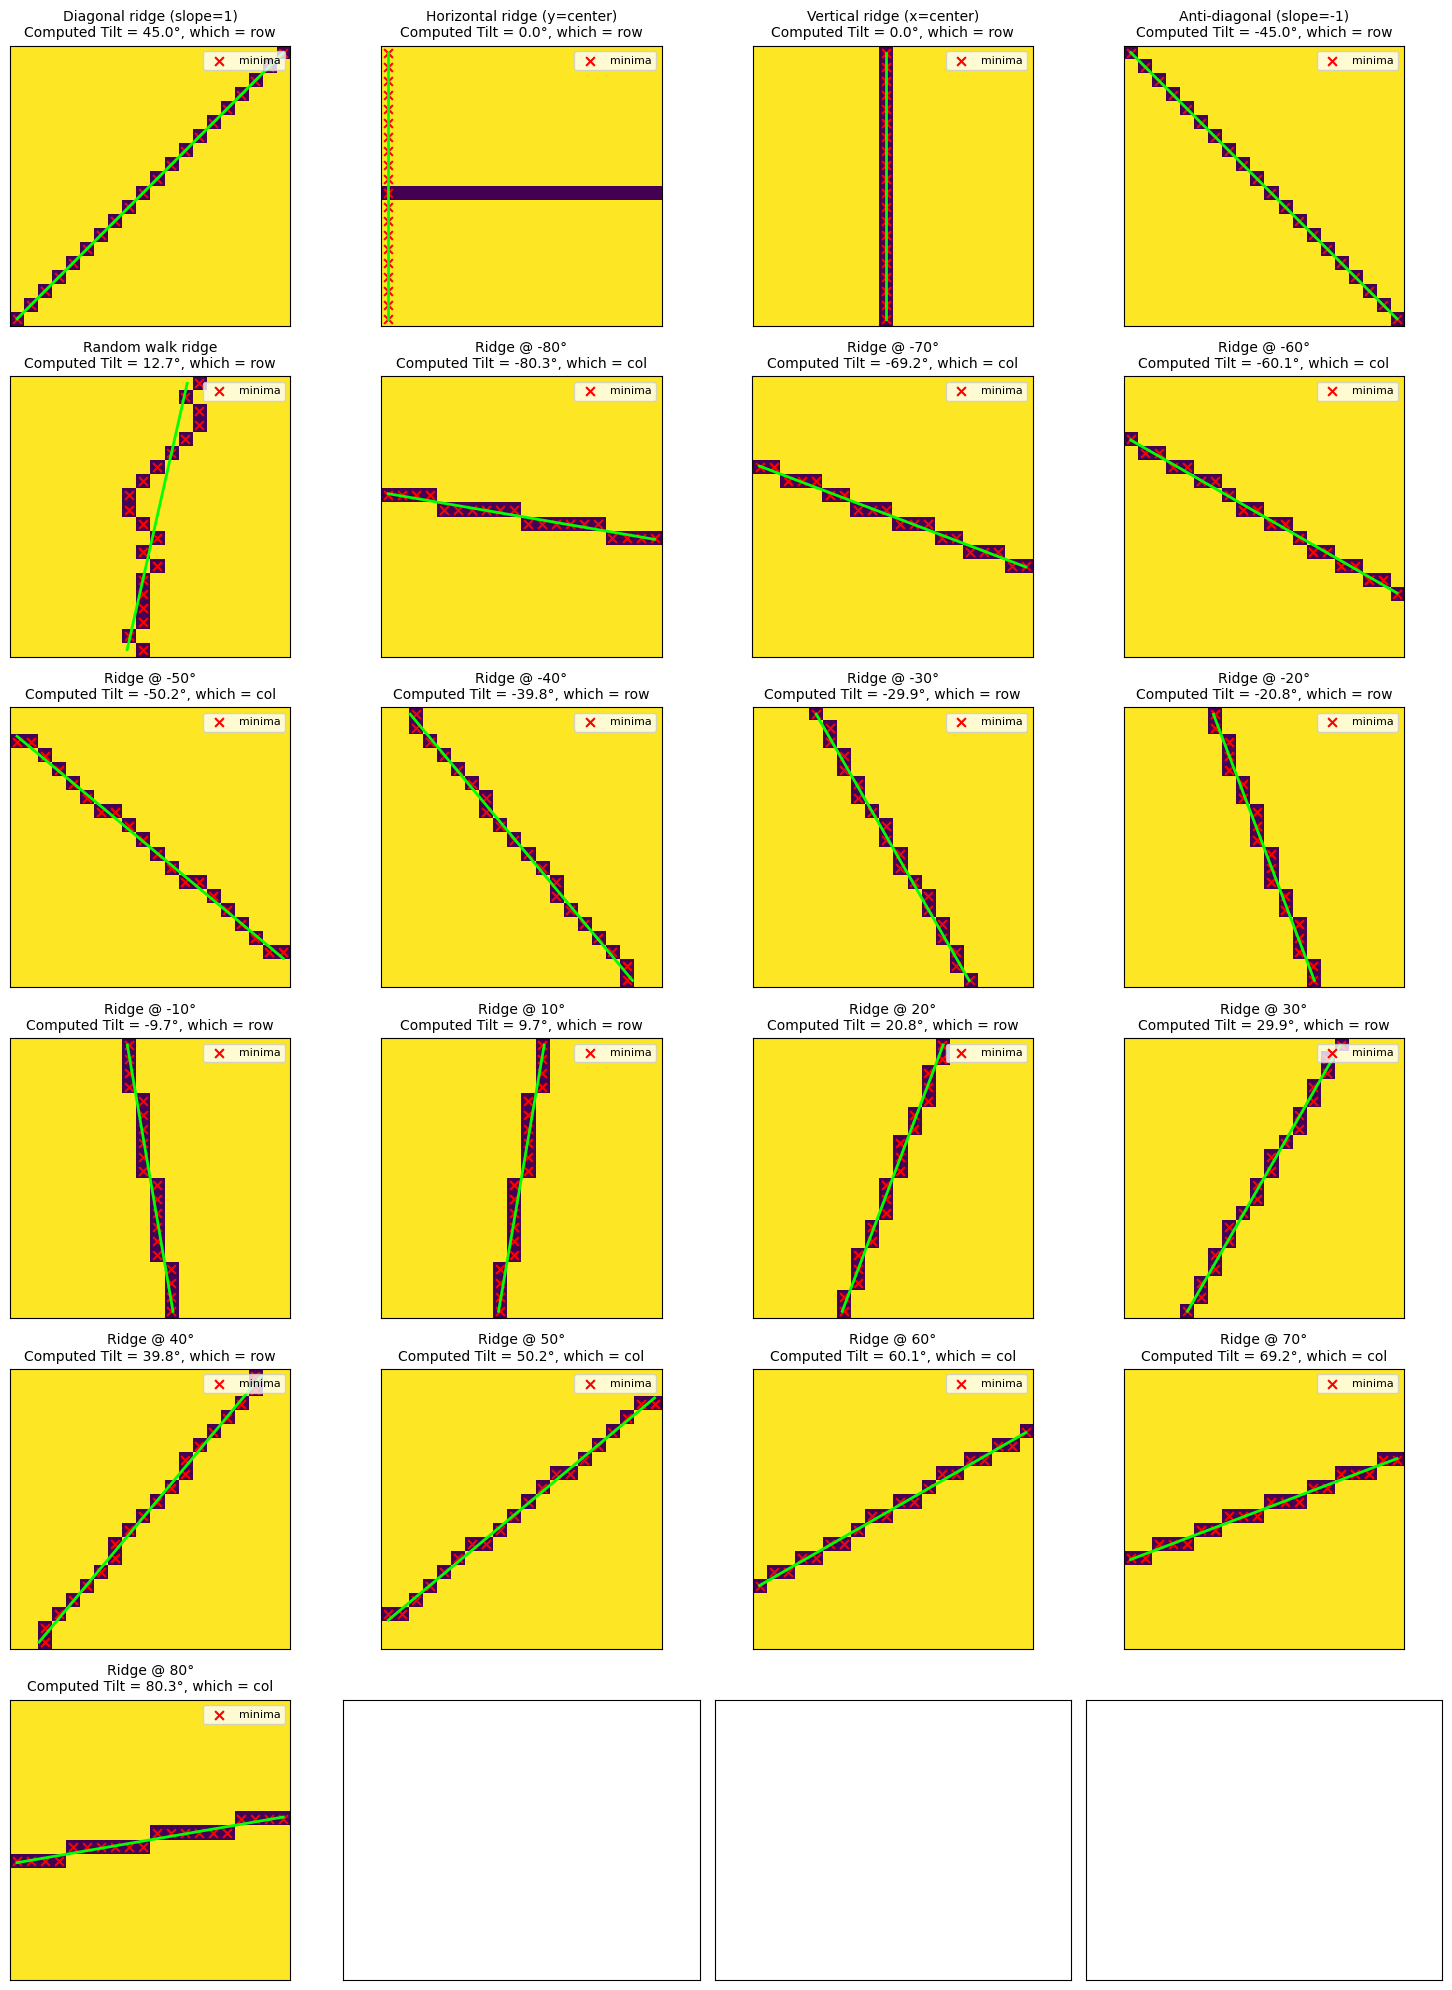

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n = 20
fig, axes = plt.subplots(6, 4, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (desc, fn, kw) in zip(axes, test_cases):
    lm = fn(n, **kw)

    # unpack: angle, slope, intercept, coords, which_fit
    angle_deg, m, b, coords, which = compute_best_tilt(
        lm,
        degrees=True,
        return_m=True,
        return_b=True,
        return_coords=True,
        mask_zeros=True,
        angle_mode='signed90',
        fit_mode=None
    )

    ax.imshow(lm, origin='lower', cmap='viridis')

    # coords is (ys, min_cols) if row-wise, or (xs, min_rows) if col-wise
    if which == 'row':
        ys, min_cols = coords
        ax.scatter(min_cols, ys, c='red', marker='x', s=40, label='minima')
    elif which == 'col':
        xs, min_rows = coords
        ax.scatter(xs, min_rows, c='red', marker='x', s=40, label='minima')
    elif which == 'vertical':
        # all minima share the same x = b
        ax.scatter([b]*n, np.arange(n), c='red', marker='x', s=40,
                   label='minima')
    else:  # horizontal
        ax.scatter(np.arange(n), [b]*n, c='red', marker='x', s=40,
                   label='minima')

    # now draw the fitted line
    if which == 'vertical':
        ax.axvline(x=b, color='lime', linewidth=2)
    elif which == 'horizontal':
        ax.axhline(y=b, color='lime', linewidth=2)
    elif which == 'row':
        y_line = np.linspace(0, n-1, 200)
        x_line = m*y_line + b
        ax.plot(x_line, y_line, 'lime', linewidth=2)
    else:  # col
        x_line = np.linspace(0, n-1, 200)
        y_line = m*x_line + b
        ax.plot(x_line, y_line, 'lime', linewidth=2)

    ax.set_title(f"{desc}\nComputed Tilt = {angle_deg:.1f}°, which = {which}", fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()


The function fails when crest is perfectly horizontal. In that case, both vertical and horizontal fits are perfect. This is because for every row there is a minima in the middle whereas for every column there is also a minimum in the middle. A more advanced algorithm is required to handle that case.